In [0]:
# Import all relevant libraries
import warnings
def fxn(): 
	warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings( ):
    warnings.simplefilter("ignore")
    fxn( )

# Keras imports
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, MaxPooling2D, Permute, Flatten, Softmax, Dense, Dropout, Conv1D, Conv2D, Conv2DTranspose, AveragePooling1D, AveragePooling2D, Activation, Reshape
from keras.utils import np_utils
from keras.optimizers import Adam

# Other
import numpy as np
import h5py
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import regularizers
import random

In [0]:
# Load data from specific trial
def get_trial(trial_num):
    trial = h5py.File('drive/shallow_1D_net/A0' + str(trial_num) + 'T_slice.mat', 'r')
    X = np.copy(trial['image'])
    y = np.copy(trial['type'])
    y = y[0,0:X.shape[0]:1]
    y = np.asarray(y, dtype=np.int32)
    y -= 769                            # shift class labels to [0-3]
    X = np.nan_to_num(X)[:, :22, :]     # remove EOG channels
    return X, y

def get_all_trials():
    X_total = np.concatenate([get_trial(trial_num)[0] for trial_num in range(1, 9)], axis=0)
    y_total = np.concatenate([get_trial(trial_num)[1] for trial_num in range(1, 9)], axis=0)
    return X_total, y_total

def stratified_train_test_split(X, y, k):
    ''' Returns a stratified train/test split, for k number of splits.
    Return value is in the form [(train indices, test indices), ... for k folds ]
    '''
    skf = StratifiedKFold(n_splits=k)
    return skf.split(X, y)

In [0]:
# Get the data from one person
num_folds = 5
# X, y = get_trial(1)
# num_trials = 1

def get_normalized_data():
    # Get the data from all the people
    X, y = get_all_trials()
    num_trials = 9
    X = np.transpose(X, (0,2,1))
    # 0 mean and unit variance
    temp = np.reshape(X, (X.shape[0], -1))
    X = np.reshape(preprocessing.scale(temp), X.shape)

    # Generate train/test split
    y_cat = keras.utils.to_categorical(y, num_classes=4)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    tt_splits = stratified_train_test_split(X_train, y_train, num_folds)

    one_hot_train = keras.utils.to_categorical(y_train)
    one_hot_test = keras.utils.to_categorical(y_test)

    return X_train, X_test, one_hot_train, one_hot_test, tt_splits

# The data for each trial is of the shape (288, 22, 1000)
#   There are 288 samples per trial (12 of each class per "run", 4 classes, 6 "runs" 
#                                   at different time periods of the day)
#   There are 22 electrodes from the EEG (represents spatial aspect of the signals)
#   There are 1000 time units (4 seconds of data, sampled at 250Hz). The first 250 units
#                                   are when no movement occurs (but the cue is heard) and
#                                   the next 750 units are when the movement occurs
# The labels for each trial belong in one of 4 classes
#   0 - left
#   1 - right
#   2 - foot
#   3 - tongue
# print(X_train.shape)
# print(X_test.shape)
# print(one_hot_train.shape)
# print(one_hot_test.shape)

In [0]:
def CNN_1D(nl=2, optimizer='adam', filters=30, lr=0.001, ld=0.0001, dp1=0.3, dp2=0.4, l2=0.05):
    # Naive implementation
    num_layers = nl
    model = Sequential()
    for _ in np.arange(num_layers):
        model.add(Conv1D(filters = filters, kernel_size = 10, activation = 'elu', input_shape = (1000,22)))
        model.add(BatchNormalization())
        model.add(Dropout(dp1))

    model.add(AveragePooling1D(pool_size=(75), strides=(15)))
    model.add(Dropout(dp2))
    model.add(Flatten())
    model.add(Dense(units=4, kernel_initializer='glorot_normal', activity_regularizer=regularizers.l2(l2), kernel_regularizer=regularizers.l2(l2), activation = 'softmax'))

    optimizer = Adam(lr=lr, decay=ld)
#     sgd = keras.optimizers.SGD(lr=0.01, momentum=0.7, decay=0.001, nesterov=True)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

running number of layers 1
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running number of layers 2
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running number of layers 3
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running number of layers 5
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running number of layers 7
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running number of layers 9
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


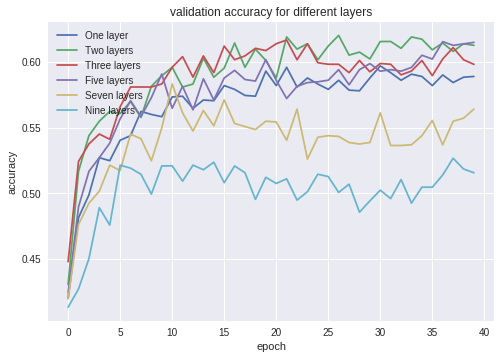

0.5889460805735818
0.6137543748030085
0.5985270954225957
0.6041348644411569
0.548399609199444
0.5085646123626971


In [22]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for nl in [1,2,3,5,7,9]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("running number of layers", nl)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(nl)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['One layer', 'Two layers', 'Three layers', 'Five layers', 'Seven layers', 'Nine layers'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/layers.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

running batch size 32
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running batch size 64
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running batch size 128
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


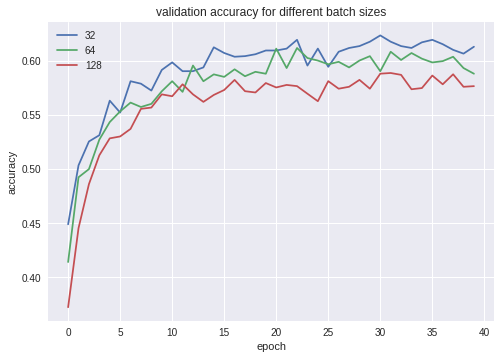

In [26]:
# batch_size = 32
num_epochs = 40
X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
history = []
for batch_size in [32, 64, 128]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("running batch size", batch_size)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i)
        model = CNN_1D(nl=2)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))
for hist_tuple in history:
    plt.plot(hist_tuple)
plt.title('validation accuracy for different batch sizes')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['One layer', 'Two layers', 'Three layers', 'Five layers', 'Seven layers', 'Nine layers'], loc='upper left')
plt.legend(['32', '64', '128'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/batches.pdf')


running optimizer adam
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running optimizer rmsprop
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running optimizer sgd
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


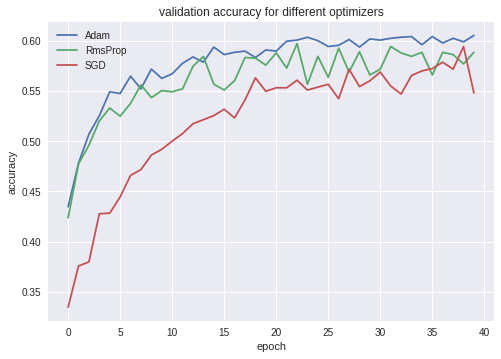

0.6015985901211832
0.5833186519151234
0.5671178134217572


In [29]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for optim in ['adam', 'rmsprop', 'sgd']:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("running optimizer", optim)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(optimizer=optim)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different optimizers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Adam', 'RmsProp', 'SGD'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/optims.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

running filter number 10
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running filter number 20
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running filter number 25
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running filter number 30
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running filter number 35
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running filter number 40
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
running filter number 50
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


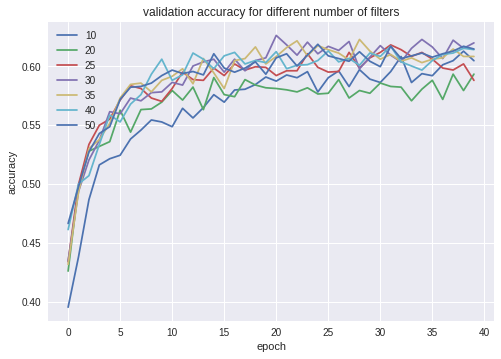

0.5984393764030675
0.582708630225064
0.6054441484261799
0.6147735569778293
0.6073918120802855
0.6080621003475237
0.6105130264537743


In [31]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for filt in [10, 20, 25, 30, 35, 40, 50]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("running filter number", filt)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(filters=filt)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different number of filters')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['10', '20', '25', '30', '35', '40', '50'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/filters.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

learning rate 0.002
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
learning rate 0.001
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
learning rate 0.0008
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
learning rate 0.0007
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
learning rate 0.0005
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


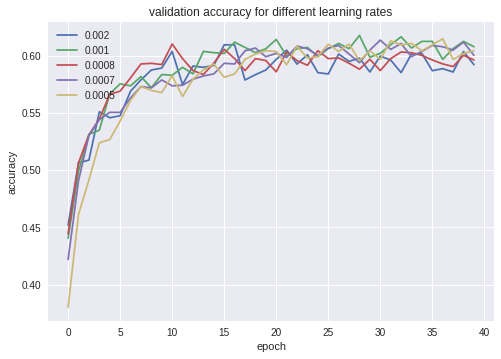

0.5939978829826913
0.6081561111112083
0.5965129836724434
0.6064948999242255
0.6059955672723973


In [33]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for lr in [0.002, 0.001, 0.0008, 0.0007, 0.0005]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("learning rate", lr)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(lr=lr)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different learning rates')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['0.002', '0.001', '0.0008', '0.0007', '0.0005'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/learning_rate.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

learning decay 0.001
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
learning decay 0.0001
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
learning decay 1e-05
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


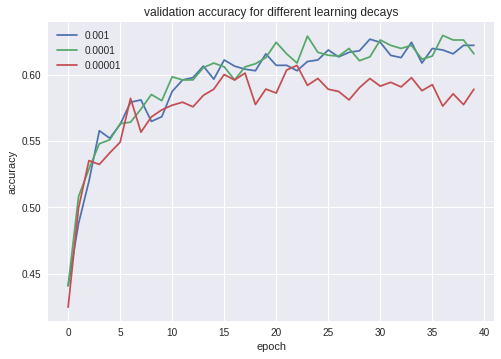

0.6183709839267916
0.6213819289861753
0.5883320154194189


In [35]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for ld in [0.001, 0.0001, 0.00001]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("learning decay", ld)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(ld=ld)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different learning decays')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['0.001', '0.0001', '0.00001'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/learning_decay.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

dropout 0.2
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.3
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.4
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.5
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.6
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


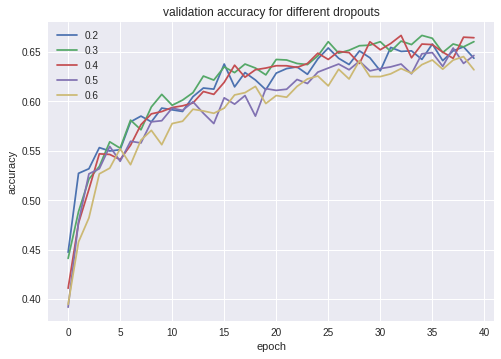

0.6478503983436676
0.6582711168460249
0.6559521834666932
0.6405121637210368
0.6344861755271214


In [37]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for dp in [0.2, 0.3, 0.4, 0.5,0.6]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("dropout", dp)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(dp1=dp)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different dropouts')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['0.2', '0.3', '0.4', '0.5', '0.6'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/dropout.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

dropout 0.2
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.3
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.4
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.5
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4
dropout 0.6
running fold 0
running fold 1
running fold 2
running fold 3
running fold 4


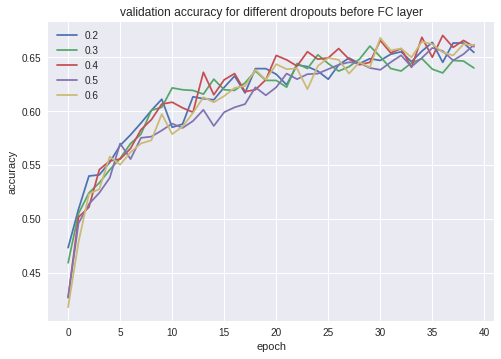

0.6545643717785125
0.6428109490895262
0.6590823191521233
0.6501331800390975
0.6587624421292946


In [40]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for dp in [0.2, 0.3, 0.4, 0.5, 0.6]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("dropout", dp)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(dp2=dp)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different dropouts before FC layer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['0.2', '0.3', '0.4', '0.5', '0.6'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/dropout2.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

In [33]:
# grid search for number of layers
batch_size = 32
num_epochs = 40
history = []
for l2 in [0.0005, 0.0001, 0.005, 0.001, 0.05]:
    X_tr, X_te, y_tr, y_te, tt_splits = get_normalized_data()
    print("l2_norm", l2)
    nl_histories = []
    for i, (train,test) in enumerate(tt_splits):
        print("running fold", i) 
        model = CNN_1D(l2=l2)
        nl_histories.append(model.fit(X_tr[train], y_tr[train], validation_data=(X_tr[test], y_tr[test]),epochs=num_epochs, batch_size=batch_size, verbose=0).history['val_acc'])
    history.append(np.average(nl_histories, axis=0))

for hist_tuple in history:
    plt.plot(hist_tuple)

plt.title('validation accuracy for different L2 norms')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['0.0005', '0.0001', '0.005', '0.001', '0.05'], loc='upper left')
plt.show()
plt.savefig('drive/shallow_1D_net/l2_norm.pdf')

for hist_tuple in history:
    print(sum(hist_tuple[-10:])/len(hist_tuple[-10:]))

OSError: ignored

In [0]:
!pip install -q keras